<a href="https://colab.research.google.com/github/Tzu-Liang/Machine-Learning-and-the-Physical-World/blob/main/Lab/gaussian-processes-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gaussian Processes - Submission Notebook
========================================



## Gaussian Processes



This notebook will form part of your individual submission for the course. The notebook will roughly mimick the parts that are in the `PDF` worksheet. Your task is to complete the code that is missing in the parts below and answer the questions that we ask. The aim is **not** for you to **solve** (I'm not actually sure what that means) the worksheet but rather for you to show your understanding of the material in the course, instead of re-running and aiming to get "perfect" results run things, make sure it is correct and then try to explain your results with a few sentences. Actually if it is not correct and you explain things well that might actually teach you more things. Importantly, be clear and concise with your answers, do not generate 15 plots that you do not refer to, instead generate a summary statistics that shows what you mean. The important thing is to provide a narrative not dump a lot of results on us.

We are going to work with GPs in exactly the same setting as in the case of linear regression. This means we are interested in the task of observing a data-set $\mathcal{D} = \{x_i, y_i \}_{i=1}^N$ where we assume the following relationship between the variates,  
$$
y_i = f(x_i).
$$
Our task is to infer the function $f(\cdot)$ from $\mathcal{D}$. We will make the same assumptions of independence as in the linear regression case which leads us to the following likelihood function,
$$
p(\mathbf{y}\vert f(\mathbf{x})) = \prod_{i=1}^N p(y_i \vert f(x_i)),
$$
where $f(x_i)$ is the output of the function at location $x_i$.

**Question 1**
Explain what the independence assumption implies? How would the likelihood look if we could not make this assumption?/

**Answer**
The independence assumption implies that each observation $y_i$ depends only on its corresponding $f(x_i)$ and not on any other observations. Hence, the joint likelihood is the product of individual likelihoods as shown in the equaiton above. Without this assumption, the joint likelihood must be expressed as a joint multivariate distributioon.

Now lets get our hands dirty and do some implementation so lets import some basic libraries that we are going to need for the lab. We will also set the random number seed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

### Prior



We will now proceed to define the prior over the function values $p(\mathbf{f})$, we will do so using a Gaussian process. The prior being non-parametric needs in addition to a set of parameters $\boldsymbol{\theta}$ also access to the location where we want to evaluate it $\mathbf{x}$. This means the distribution that we are going to parametrise is,
$$
p(\mathbf{f}\mid \mathbf{x},\boldsymbol{\theta}) = \mathcal{N}\left(\mathbf{f}\mid \mu(\mathbf{x}, k(\mathbf{x},\mathbf{x}) \right).
$$
We will begin by implementing the co-variance function $k(x_i,x_j)$. We will play around with



In [2]:
def rbf_kernel(x1, x2, varSigma, lengthscale):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)

    return varSigma*np.exp(-np.power(d, 2)/lengthscale)

def lin_kernel(x1, x2, varSigma):
    if x2 is None:
        return varSigma*x1.dot(x1.T)
    else:
        return varSigma*x1.dot(x2.T)

def white_kernel(x1, x2, varSigma):
    if x2 is None:
        return varSigma*np.eye(x1.shape[0])
    else:
        return np.zeros(x1.shape[0], x2.shape[0])

def periodic_kernel(x1, x2, varSigma, period, lengthScale):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    return varSigma*np.exp(-(2*np.sin((np.pi/period)*d)**2)/lengthScale**2)

**Question 2** Evaluate the four covariance functions implemented above for a one dimensional index set, say `x = np.linspace(-6,6,100).reshape(-1,1)` and plot the result using `plt.imshow()`. Play around with the input parameters to the co-variance functions to make sure you have an idea of what they do and how the alter the matrix. Explain briefly why the matrices look the way they do and what it will imply for which functions we find likely. Here we have worked with a one-dimensional input data, how would things change if our input domain where say four dimensional?

**Answer**

In [3]:
from ipywidgets import interact
@interact(
    varSigma=(0.1, 3.0, 0.1),
    lengthscale=(0.1, 2, 0.1),
    period=(0.1, 5.0, 0.1)
)
def plot_kernels(varSigma=1.0, lengthscale=1.0, period=1.0):
    # Input grid
    x = np.linspace(-6, 6, 100).reshape(-1, 1)

    # Compute covariance matrices
    rbf_cov = rbf_kernel(x, None, varSigma, lengthscale)
    lin_cov = lin_kernel(x,None,varSigma)
    white_cov = white_kernel(x,None,varSigma)
    periodic_cov = periodic_kernel(x, None, varSigma, period, lengthscale)


    # Plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    im1 = axs[0,0].imshow(rbf_cov, cmap='viridis', origin='lower', extent= [-6,6,-6,6])
    axs[0,0].set_title(f'RBF Kernel\nσ²={varSigma:.2f}, ℓ={lengthscale:.2f}')
    plt.colorbar(im1, ax=axs[0,0], fraction=0.046, pad=0.04)

    im2 = axs[0,1].imshow(lin_cov, cmap='viridis', origin='lower', extent= [-6,6,-6,6])
    axs[0,1].set_title(f'Linear Kernel\nσ²={varSigma:.2f}')
    plt.colorbar(im2, ax=axs[0,1], fraction=0.046, pad=0.04)

    im3 = axs[1,0].imshow(white_cov, cmap='viridis', origin='lower', extent= [-6,6,-6,6])
    axs[1,0].set_title(f'White Noise Kernel\nσ²={varSigma:.2f}')
    plt.colorbar(im3, ax=axs[1,0], fraction=0.046, pad=0.04)

    im4 = axs[1,1].imshow(periodic_cov, cmap='viridis', origin='lower', extent= [-6,6,-6,6])
    axs[1,1].set_title(f'Periodic Kernel\nσ²={varSigma:.2f}, p={period:.2f}, ℓ={lengthscale:.2f}')
    plt.colorbar(im4, ax=axs[1,1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()



interactive(children=(FloatSlider(value=1.0, description='varSigma', max=3.0, min=0.1), FloatSlider(value=1.0,…

# RBF:

*   Shows a bright diagonal band (high correlance)
*   Nearby points are hightly correlated, but far points are weekly correlated
*   Saller lengthscale -> thinner digonal band -> rapdily varying functions;
*   Larger lenghtscale -> wider band -> slowly varying fucntions.
*   Likely Functions: Smooth and continuous

# Linear:

*   Behaves like A smooth gradient pattern
*   Correlation depends on the product $x_ix_j$
*   Changes sign across zero: postive when $x_i$ and $x_j$ have the same sign, negative otherwise
*   Likely Functions: Linear trends

# White Noise:

*   Indentity matrix scaled by the same weight varSigma, zero elsewhere
*   No correlations between different inputs ($i\neq j$)
*   Likely Functions: Purely random and uncorrelated observations

# Periodic:

*   Repeats diagonal bands spaced by a period
*   More peeks with lower period
*   Saller lengthscale -> thinner digonal band -> rapdily varying functions;
*   Larger lenghtscale -> wider band -> slowly varying fucntions.
*   Likely Functions: Cyclical and repeating

In higher dimensions (e.g., four dimensions), the overall appearance of the covariance matrices for different kernels remains similar. However, for distance-based kernels (such as the RBF and Periodic kernels), the correlations change significantly because the average distance between data points increases with dimensionality. Hence, the functions tend to vary more rapidly unless the lengthscales are adjusted. Moreover, there are multiple lengthscale parameters: one for each dimension (as in Automatic Relevance Determination, ARD). By inspecting the optimised lengthscales, a small lengthscale indicates that the corresponding dimension is highly relevant, while a large lengthscale suggests that the dimension is less relevant to explaining the variation in the data.


Now when we have implemented the co-variance function we can generate samples from the prior. We can use the function `np.random.multivariate_normal()` in order to sample points from a multi-variate Gaussian. We will use a zero-mean process so the mean function is just constant $0$.



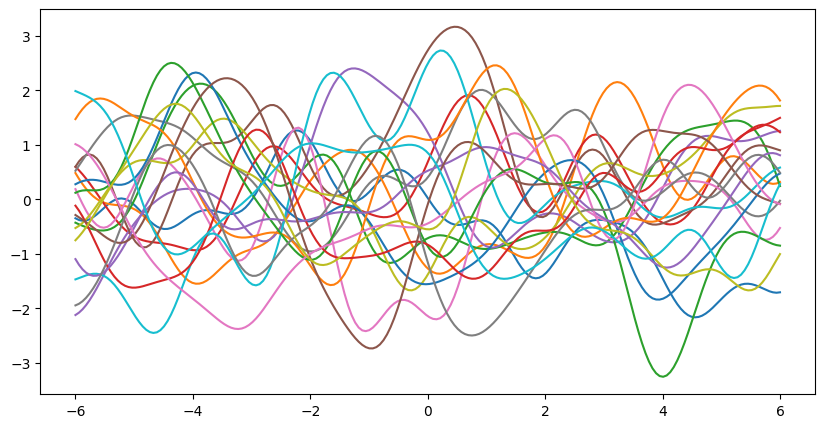

In [4]:
x = np.linspace(-6,6,200).reshape(-1,1)
K = rbf_kernel(x,x,1,1)
mu = np.zeros(x.shape)

f = np.random.multivariate_normal(mu.flatten(), K, 20)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(x, f.T)

Play around a little bit with the parameters of the co-variance function and generate samples. Try to build up a notion of how the samples are controlled by the parametrisation. Make sure that you can get the connection between the co-variance matrix that we visualised and the samples that you see.

One interesting thing about co-variance functions are that they are closed under lots of operations. This means that you can combine them in different ways. Try to generate samples from a process where your prior is the `sum` the `product` of several of these functions. Experiment with this a bit, here is where you can input a lot of knowledge into the system.



### Posterior



Now when we have seen samples from the prior it is time to merge these assumptions with observed data. The first thing we will do is to generate some data in a way that we allow us to test things. We will generate two data-sets, a one-dimensional and a two-dimensional function.



In [5]:
def data_1d(N, noise):
    x = np.linspace(-5,5,N)
    # x = np.random.randn(N)
    # x = np.sort(x)
    y = -(-np.sin(3*x) - x**2 + 0.7*x) + noise*np.random.randn(x.shape[0])

    return x,y


def data_2d(N, noise):
    xg = np.linspace(-4,4,N)
    x1, x2 = np.meshgrid(xg,xg)
    x1 = x1.flatten()
    x2 = x2.flatten()

    y = (x1**2+x2-11)**2 + (x1+x2**2-7)**2

    X = np.stack((x1,x2)).T

    return X, y

Now when we have some data we will get our updated belief about the function values given the prior assumptions and the data we have observed. To do so we need to formulate the predictive distribution of the Gaussian process.

**Question 3** Explain how we reach the updated belief about our function given the data? What is the specific process that we have to go through? Explain this both for any general model and what is unique (rather unique actually) about how we do this using a Gaussian process prior?

**Answer** For any general models, we can use Bayesian inference to update the belief about the function given the data. Bayesian inference combines the prior belief (initial knowledge) with the likelihood (observations) to produce the posterior belief. Mathematically, the posterior is given by Bayes’ rule

$$P(\mathbf{w}\mid \mathbf{y}, \mathbf{x})=\frac{P(\mathbf{w})P(\mathbf{y}\mid\mathbf{x},\mathbf{w})}{P(\mathbf{y})},$$

where $P(\mathbf{w})$ is the prior belief, $P(\mathbf{y}\mid\mathbf{x},\mathbf{w})$ is the likelihood, and $P(\mathbf{y})$ is the evidence. In general models, this posterior often cannot be computed analytically and must be approximated.

As for Gaussian process prior, the unique property is that when assuming likelihood (observation noise) is Gaussian, the posterior distribution also is a multivariate gaussian and can be easily computed analytically in a closed form.

**Question 4** Now look first at the formulation of the predictive posterior. We can see that the posterior variance consists of two terms, one subtracted from the other. Explain what the effect of these two terms are and try to provide an intuition of how it leads to the posterior variance. One good way to do this is to plot each of the terms individually.

**Answer** For Gaussian process, the predictive posterior variance is given by

$$
  Cov(f_*)=k(\mathbf{x_*},\mathbf{x_*})-k(\mathbf{x_*},\mathbf{x})^Tk(\mathbf{x},\mathbf{x})^{-1}k(\mathbf{x},\mathbf{x_*}).
$$
The first term $k(\mathbf{x_*},\mathbf{x_*})$ is the prior covariance between test points. It represents the uncertainty before seeing the data. For the RBF kernel, nearby points have large covaraince, while far points have small covariance. The terms $k(\mathbf{x_*},\mathbf{x})$ and $k(\mathbf{x},\mathbf{x_*})$ are cross-covariances between test and train points, and $k(\mathbf{x},\mathbf{x})$ is the covaraince between training points. Hence, the second term $k(\mathbf{x_*},\mathbf{x})^Tk(\mathbf{x},\mathbf{x})^{-1}k(\mathbf{x},\mathbf{x_*})$ represets the information gained from the observed data. As we observe data $x_*$, this term increases and thus reduces the predictive variance. Therefore, the predictive variance becomes smaller near observed points and larger farther away.

In [6]:
# 1-dimensional data
@interact(
    M =(1,20,1),
    varSigma=(0.1, 3.0, 0.1),
    lengthscale=(0.1, 2, 0.1),
    noise=(0.1, 5.0, 0.1))

def plot_cov(M=5, varSigma=1, lengthscale=1, noise=.1):

  N=500
  x, y = data_1d(M, noise=0)
  x = x.reshape(-1, 1)
  y = y.reshape(-1, 1)

  x_star = np.linspace(-6, 6, N).reshape(-1,1)

  K_XX = rbf_kernel(x, None, varSigma, lengthscale)  # (M, M)
  K_Xs_X = rbf_kernel(x_star, x, varSigma, lengthscale)  # (N,M)
  K_Xs_Xs = rbf_kernel(x_star, None, varSigma, lengthscale)  # (N, N)



  # Term 1:
  term1_prior_variance = K_Xs_Xs  # Shape: (M,M)

  # Term 2:
  K_XX_inv = np.linalg.inv(K_XX)  # (N, N)
  term2_reduction = K_Xs_X @ K_XX_inv @ K_Xs_X.T  # Shape: (M,M)

  fig, axs = plt.subplots(2, 2, figsize=(10, 8))

  im1 = axs[0,0].imshow(term1_prior_variance, cmap='viridis', origin='lower', extent= [-6,6,-6,6])
  axs[0,0].set_title(f'term1_prior_variance (1D data)')
  plt.colorbar(im1, ax=axs[0,0], fraction=0.046, pad=0.04)

  im2 = axs[0,1].imshow(term2_reduction, cmap='viridis', origin='lower', extent= [-6,6,-6,6])
  axs[0,1].set_title(f'term2_reduction (1D data)')
  plt.colorbar(im2, ax=axs[0,1], fraction=0.046, pad=0.04)

  im3 = axs[1,0].imshow(term1_prior_variance-term2_reduction, cmap='viridis', origin='lower', extent= [-6,6,-6,6])
  axs[1,0].set_title(f'Posterior covariance (1D data)')
  plt.colorbar(im2, ax=axs[1,0], fraction=0.046, pad=0.04)

  axs[1, 1].axis('off')

  plt.tight_layout()
  plt.show()



interactive(children=(IntSlider(value=5, description='M', max=20, min=1), FloatSlider(value=1.0, description='…

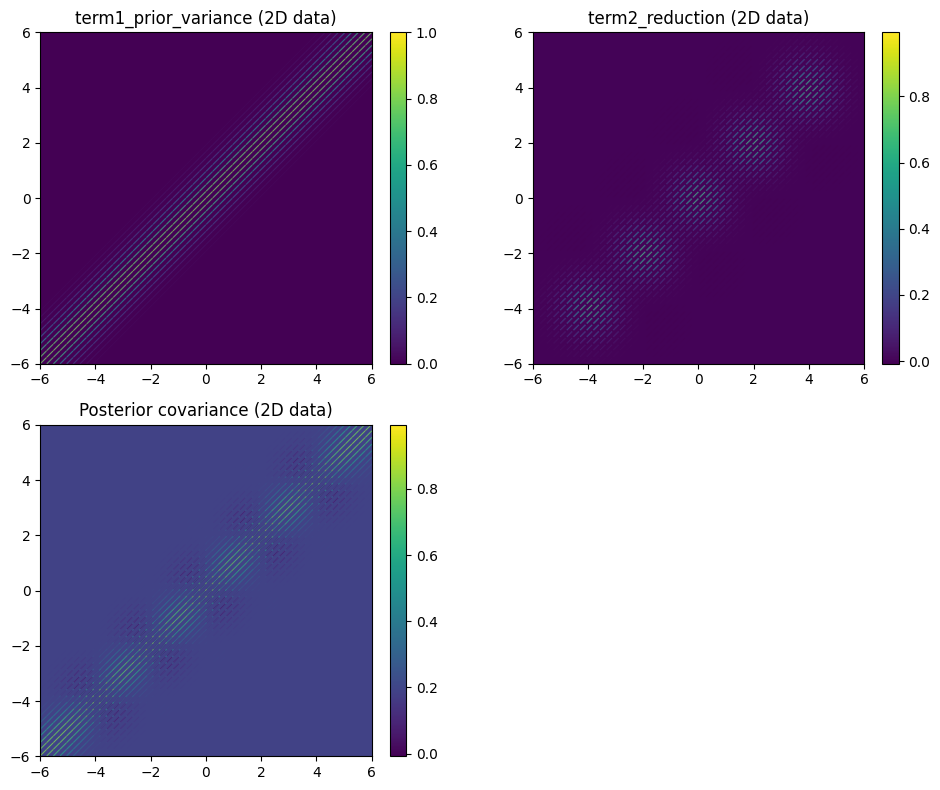

In [7]:
# 2-dimensional Data
M= 5
N= 50
noise = .1
X, y = data_2d(M, noise)
X = X.reshape(-1, 2)
y = y.reshape(-1, 1)

X_star = np.linspace(-6, 6, N).reshape(-1,1)
X_star1, X_star2 = np.meshgrid(X_star,X_star)
X_star = np.stack((X_star1.flatten(),X_star2.flatten())).T

K_XX = rbf_kernel(X, None, 1, 1)  # (M, M)
K_Xs_X = rbf_kernel(X_star, X, 1, 1)  # (N,M)
K_Xs_Xs = rbf_kernel(X_star, None, 1, 1)  # (N, N)



# Term 1:
term1_prior_variance = K_Xs_Xs  # Shape: (M,M)

# Term 2:
K_XX_inv = np.linalg.inv(K_XX)  # (N, N)
term2_reduction = K_Xs_X @ K_XX_inv @ K_Xs_X.T  # Shape: (M,M)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

im1 = axs[0,0].imshow(term1_prior_variance, cmap='viridis', origin='lower', extent= [-6,6,-6,6])
axs[0,0].set_title(f'term1_prior_variance (2D data)')
plt.colorbar(im1, ax=axs[0,0], fraction=0.046, pad=0.04)

im2 = axs[0,1].imshow(term2_reduction, cmap='viridis', origin='lower', extent= [-6,6,-6,6])
axs[0,1].set_title(f'term2_reduction (2D data)')
plt.colorbar(im2, ax=axs[0,1], fraction=0.046, pad=0.04)

im3 = axs[1,0].imshow(term1_prior_variance-term2_reduction, cmap='viridis', origin='lower', extent= [-6,6,-6,6])
axs[1,0].set_title(f'Posterior covariance (2D data)')
plt.colorbar(im2, ax=axs[1,0], fraction=0.046, pad=0.04)

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


Now let us implement the predictive posterior evaluated at data `x1, y1` and evaluated at `xstar`. You might want to be a bit more clever and implement a generic function that takes the matrices as input instead so that you can try different co-variance functions.

In [8]:
def gp_prediction(x1, y1, xstar, lengthScale, varSigma):

	k_starX = rbf_kernel(x_star, x, varSigma, lengthScale)  # (N,M)
	k_xx = rbf_kernel(x, None, varSigma, lengthScale)  # (M, M)
	k_starstar = rbf_kernel(x_star, None, varSigma, lengthScale)  # (N, N)

	mu = k_starX.dot(np.linalg.inv(k_xx)).dot(y1)
	var = k_starstar - (k_starX).dot(np.linalg.inv(k_xx)).dot(k_starX.T)

	return mu, var

/tmp/ipython-input-2596996158.py:28: MatplotlibDeprecationWarning: Passing the marker parameter of scatter() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax1.scatter(x, y, 200,'k','*', zorder=2)
/tmp/ipython-input-2596996158.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


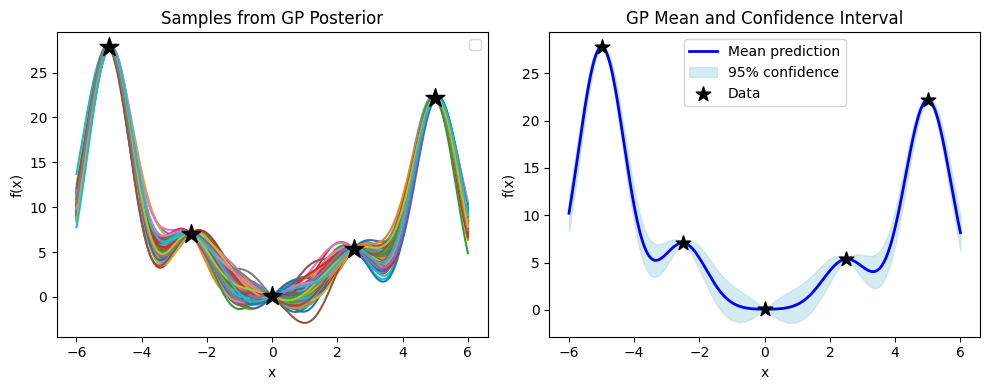

In [9]:
# 1D data

Nsamp = 100
N = 500
M = 5
noise = .1

x, y = data_1d(M, noise)
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
x_star = np.linspace(-6, 6, N).reshape(-1, 1)

# --- GP prediction ---
mu_star, cov_star = gp_prediction(x, y, x_star, lengthScale=1, varSigma=1)
fstar = np.random.multivariate_normal(mu_star.flatten(), cov_star, Nsamp)
mu = mu_star.ravel()
std = np.sqrt(np.clip(np.diag(cov_star), 0, None))

# Add jitter for numerical stability when sampling
cov_for_sampling = cov_star + 1e-6 * np.eye(N)
f_samples = np.random.multivariate_normal(mu, cov_for_sampling, Nsamp)

# --- Create subplots (1 row, 2 columns) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ---- Left plot: Posterior samples ----
ax1.plot(x_star, fstar.T)
ax1.scatter(x, y, 200,'k','*', zorder=2)
ax1.set_title('Samples from GP Posterior', fontsize=12)
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.legend()


ax2.plot(x_star.ravel(), mu, 'b', lw=2, label='Mean prediction')
ax2.fill_between(
    x_star.ravel(),
    mu - 2 * std,
    mu + 2 * std,
    color='lightblue',
    alpha=0.5,
    label='95% confidence'
)
ax2.scatter(x.ravel(), y.ravel(), s=120, c='k', marker='*', zorder=3, label='Data')
ax2.set_title('GP Mean and Confidence Interval', fontsize=12)
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.legend()

plt.tight_layout()
plt.show()


In the final step covering the material that we have covered in the lectures we are now going to include the likelihood function that we first specified and write down the predictive posterior. This alters the posterior to the one below if we have a likelihood with precision $\beta$.

\begin{align}
p(\mathbf{f}_*\vert \mathbf{y}, \mathbf{x},\mathbf{x}_*,\theta) &= \mathcal{N}(\mu_{\mathbf{x}_*\vert \mathbf{x}}, K_{\mathbf{x}_*\vert \mathbf{x}})\\
\mu_{\mathbf{x}_*\vert \mathbf{x}} &= k(\mathbf{x}_*,\mathbf{x})\left(k(\mathbf{x},\mathbf{x})+\frac{1}{\beta}\mathbf{I}\right)^{-1}\mathbf{y}\\
K_{\mathbf{x}_*\vert \mathbf{x}} &= k(\mathbf{x}_*,\mathbf{x}_*) - k(\mathbf{x}_*,\mathbf{x})\left(k(\mathbf{x},\mathbf{x})+\frac{1}{\beta}\mathbf{I}\right)^{-1}k(\mathbf{x},\mathbf{x}_*).
\end{align}

**Question 5** Explain why the predictive posterior changes in the way it does? How does the samples of the function change from when we did not include this term? Think about the concept of "explaining away" that we discussed during the lectures.

**Answer**


1.   With precision term, each oberservation is not exactly prodcued from the true underlying process. Hence, the functions would not pass through the dat points. They can deviate slightly due to noise, causing that the predictive uncertainty around the data points slightly increases. With higher $\beta$, the functions are more closed the data poits.
With higher $\beta$, the GP model believes the data are more reliable, so the functions are closer to the data points and the confidence band narrows.

2.   Since the functions now do not necessarily pass through the data points, the posterior predictions become less constrained by the obeservations. The prediction gives smoother fucntions and avoids overfitting.

3.  Explaining away: With noise controlled by $\beta$, the variation in the data can now be explained away by the precision $\beta$, rathr than being attributed entirely to the function $\mathbf{f}$.




In [37]:
def gp_prediction(x1, y1, xstar, lengthScale, varSigma, noise):

	k_starX = rbf_kernel(xstar,x1,lengthScale,varSigma,noise)
	k_xx = rbf_kernel(x1, None, lengthScale, varSigma, noise)
	k_starstar = rbf_kernel(xstar,None,lengthScale,varSigma,noise)

	mu = k_starX.dot(np.linalg.inv(k_xx)).dot(y1)
	var = k_starstar - (k_starX).dot(np.linalg.inv(k_xx)).dot(k_starX.T)

	return mu, var


def rbf_kernel(x1,x2,lengthScale,varSigma,noise):
    if x2 is None:
        d = cdist(x1, x1)
        k = varSigma*np.exp(-np.power(d, 2)/lengthScale) + noise * np.eye(x1.shape[0])
    else:
        d = cdist(x1, x2)
        k = varSigma*np.exp(-np.power(d, 2)/lengthScale)

    return k

# --- Interactive plot function ---
@interact(noise=(0, .1, 1e-3),lengthScale=(.01, 2, .01))
def plot_gp(noise=0.05, lengthScale = 1):

# --- Generate 1D data ---
    Nsamp = 10
    N = 500
    M = 5
    x, y = data_1d(M, noise=.1)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    x_star = np.linspace(-6, 6, N).reshape(-1, 1)

    mu_star, cov_star = gp_prediction(x, y, x_star, lengthScale=lengthScale, varSigma=1, noise=noise)
    mu = mu_star.ravel()
    std = np.sqrt(np.diag(cov_star))
    f_samples = np.random.multivariate_normal(mu, cov_star, Nsamp)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ---- Left plot: Posterior samples ----
    ax1.plot(x_star, f_samples.T)
    ax1.scatter(x, y, 200,'k','*', zorder=2)
    ax1.set_title(f'Samples from GP Posterior (Noise={noise:.2f})', fontsize=12)
    ax1.set_xlabel('x')
    ax1.set_ylabel('f(x)')

    # ---- Right plot: Mean + Confidence Interval ----
    ax2.plot(x_star.ravel(), mu, 'b', lw=2, label='Mean prediction')
    ax2.fill_between(
        x_star.ravel(),
        mu - 2 * std,
        mu + 2 * std,
        color='lightblue',
        alpha=0.5,
        label='95% confidence'
    )
    ax2.scatter(x.ravel(), y.ravel(), s=200, c='k', marker='*', zorder=3, label='Data')
    ax2.set_title(f'GP Mean and Confidence Interval (noise={noise:.2f})', fontsize=12)
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')
    ax2.legend()

    plt.tight_layout()
    plt.show()


interactive(children=(FloatSlider(value=0.05, description='noise', max=0.1, step=0.001), FloatSlider(value=1.0…

### Learning



In this final part we will go a bit beyond the material that we have covered in the lectures. So far we have specified the Gaussian process prior, performed the marginalisation and computed the predictive posterior. In this case the hyper-parameters, the parameters of the co-variance function have been fixed. We will now proceed to optimise the marginal likelihood as a way of "learning" the parameters. This means that our learning task is to,
$$
\hat{\boldsymbol{\theta}} = \operatorname{argmax}_{\boldsymbol{\theta}} p(\mathbf{y}\mid\mathbf{X},\boldsymbol{\theta}).
$$
Now in order to make things a little bit nicer for us to optimise we are instead of looking at the likelihood going to use the negative log-marginal likelihood instead and try to find the parameters that minimises this,
$$
\hat{\boldsymbol{\theta}} = \operatorname{argmin}_{\boldsymbol{\theta}} - \textrm{log}\left( p(\mathbf{y}\mid\mathbf{X},\boldsymbol{\theta})\right) = \mathcal{L}(\boldsymbol{\theta})
$$

Now lets write up the log-marginal likelihood,
$$
\operatorname{log} p(\mathbf{y}\mid \mathbf{X}, \boldsymbol{\theta}) = \int p(\mathbf{y}\mid \mathbf{f})p(\mathbf{f}\mid \mathbf{X},\boldsymbol{\theta})\textrm{d}\boldsymbol{\theta}
$$
$$
-\frac{1}{2}\mathbf{y}^{\textrm{T}}\left(k(\mathbf{x},\mathbf{x})\right)^{-1}\mathbf{y} - \frac{1}{2}\operatorname{log}\operatorname{det}\left(k(\mathbf{x},\mathbf{x}-\beta^{-1}\mathbf{I}\right) - \frac{N}{2}\operatorname{log}2\pi = -\mathcal{L}(\boldsymbol{\theta})
$$

We will perform the optimisation using a gradient based optimiser. This means that we need to compute the gradients of the loss-function $\mathcal{L}$ with respect to $\boldsymbol{\theta}$. While these gradients are not very hard to compute by hand, and you are more than free to do so, we can also use packages that can handle `auto-differentiation`. There are lots of them around but my preference is to use `jax` which nicely follows `numpy`. Below is some scaffolding to a simple gradient based optimisation loop.



In [11]:
from jax import grad
import jax.numpy as jnp

def squared_exponential(x1, x2, theta):
    # theta[0] - variance
    # theta[1] - lengthscale
    # theta[2] - noise variance
    if x2 == None:
        return theta[0]*jnp.exp(-cdist(x1, x1, metric='sqeuclidean')/theta[1]**2) + (1/theta[2])*jnp.eye(x.shape[0])
    else:
        return theta[0]*jnp.exp(-cdist(x1, x2, metric='sqeuclidean')/theta[1]**2)

def logmarginal_likelihood(x, y, theta):
    # implement the log-marginal likelihood of a GP


  dLdtheta = grad(logmarginal_likelihood, argnums=3)(..)
  for i in range(1000):

      theta -= dLdtheta(theta) * 0.01




SyntaxError: invalid syntax (ipython-input-4207638522.py, line 16)

Finish the code above and try to learn the hyper-parameters given a set of observed data. You might want to use data that is quite noisy and where you do not have too many data-points to avoid some computational issues that might emerge. If you are finding that the optimisation somehow crashes, try to remove `theta[2]` from the optimisation and make it a fixed value.

**Question 6** Show a plot where you show both the predictive posterior of the initial setting (the start values of $\boldsymbol{\theta}$ and the optimised values. Explain the results.

**Answer**

**Question 7** In the co-variance function `def squared_exponential` above we have two linear parameters `theta[0]` and `theta[2]` that scales the two terms of the function. Interpret these two parameters, what does the relation between the two mean? Hint: rather than thinking about precision think about `1/theta[2]` which is related to the variance.

**Answer**

*For these last questions you are quite likely not to get the code running in a stable way for the general case and you probably have an idea why from the lecture. Instead try and find something that runs and describe why you think this special case works.*



### Submission



Now you are done with this notebook and hopefully you feel that you have a good understanding of Gaussian processes both in theory and in practice. The key thing when we move onto to the next parts of the course is that you start building up an intuition for what you can do with these models, how you can alter things, what assumptions/knowledge that are easy to encode etc. Please submit your notebook on `Moodle` before the deadline which is **Thursday 29th of October 12:00**

